In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('popular')

from nltk.tokenize import sent_tokenize, word_tokenize

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Package movie_reviews is already up-to-date!
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Package names is already up-to-date!
[nltk_data]    | Do

In [2]:
# Defining constants used in the code
SAMPLE_PERCENTAGE = 0.20
FIRST_N_RECORDS = 10

**Reading data and removing unnecessary cloumns and data**




In [3]:
file_path = 'https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv'
df = pd.read_csv(file_path, encoding='ISO-8859-1', names=['label','tweet'])

# To Remove top row from a dataframe
df = df[1:] 

# To show the full column
pd.set_option('display.max_colwidth', None) 

print(df.shape)
df.head(FIRST_N_RECORDS)

(31962, 2)


,label,tweet
1,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
2,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
3,0,bihday your majesty
4,0,#model i love u take with u all the time in urÃ°ÂÂÂ±!!! Ã°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂÃ°ÂÂÂ Ã°ÂÂÂ¦Ã°ÂÂÂ¦Ã°ÂÂÂ¦
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before they leave. chaos and pay disputes when they get there. #allshowandnogo
7,0,@user camping tomorrow @user @user @user @user @user @user @user dannyÃ¢ÂÂ¦
8,0,the next school year is the year for exams.Ã°ÂÂÂ¯ can't think about that Ã°ÂÂÂ­ #school #exams #hate #imagine #actorslife #revolutionschool #girl
9,0,we won!!! love the land!!! #allin #cavs #champions #cleveland #clevelandcavaliers Ã¢ÂÂ¦
10,0,@user @user welcome here ! i'm it's so #gr8 !


**To get some percentage of the data as sample for modelling in terms of reducing the computation burden**

In [4]:
sample_size = int(np.array(df.shape[0])*SAMPLE_PERCENTAGE)
df = df.sample(sample_size, replace=False)
print(f"Sample size is {sample_size}")
print(f"Sample data dimension is {df.shape}")


Sample size is 6392
Sample data dimension is (6392, 2)


In [5]:
df.head(FIRST_N_RECORDS)

,label,tweet
10753,0,@user oooo tomorrow Ã°ÂÂÂ¸Ã°ÂÂÂ¶
7895,0,"i opened ""my"" #rollerblade season, today! #summer #rollerblading #belgrade #adaciganlija"
30918,0,father day Ã³Â¾Â¬Â
15004,0,#hype 40 min to go #super #oneplus3 @user @user @user
20044,0,"while i am eating breakfast, i hear the sad sounds of packing. this vacation has seemed shoer than the others."
29752,0,"@user oh noooo, don't re-write! you'll be fine just going with the flow, it will be epic. ;) #oustudents16 #cantsleeptonight"
14281,0,happy 6th bihday junior Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤Ã°ÂÂÂ i hope you have the best day!Ã°ÂÂÂÃ°ÂÂÂ@user bihday #cristiano #cr7 Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤
477,0,happy bihday to me!... brithday day holidays #monday #menmodelsÃ¢ÂÂ¦
6277,0,@user i freaking #love #this! #selfies #alldayeveryday if it makes you ! Ã°ÂÂÂÃ°ÂÂÂ #goodhairday? #makeup #onpoint? selfieÃ°ÂÂÂ·
31401,0,@user : find out which nationalities are happy for most of their days -


In [6]:
# Removing duplicate records
def drop_duplicate_records(df):
  num_of_duplicate_records = len(df)-len(df.drop_duplicates(inplace=False))
  df.drop_duplicates(inplace=True)
  print(f"{num_of_duplicate_records} duplicate records are dropped.\nThe number of unique records is {df.shape[0]}")

In [7]:
drop_duplicate_records(df)

280 duplicate records are dropped.
The number of unique records is 6112


In [8]:
# To explore the data
df.describe()

,label,tweet
count,6112,6112
unique,2,6112
top,0,"be with what you have, while still #working for what you want #mavikbeb"
freq,5719,1


In [9]:
# To check the missing/null values
df.isnull().sum()

label    0
tweet    0
dtype: int64

**Removing the Twitter Handles and Hashtags**




In [10]:
def remove_pattern(input_txt, pattern):
  '''
  This removes the twitter handles from the pandas dataframe
  https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python 

  '''
  r = re.findall(pattern, input_txt)
  for i in r:
      input_txt = re.sub(i, '', input_txt)
  return input_txt    

In [11]:
# To remove the twitter handles
df['tweet'] = np.vectorize(remove_pattern)(df['tweet'], "@[\w]*") 
# df['tweet'] = np.vectorize(remove_pattern)(df['tweet'], "#[\w]*") 
df.head(FIRST_N_RECORDS)

,label,tweet
10753,0,oooo tomorrow Ã°ÂÂÂ¸Ã°ÂÂÂ¶
7895,0,"i opened ""my"" #rollerblade season, today! #summer #rollerblading #belgrade #adaciganlija"
30918,0,father day Ã³Â¾Â¬Â
15004,0,#hype 40 min to go #super #oneplus3
20044,0,"while i am eating breakfast, i hear the sad sounds of packing. this vacation has seemed shoer than the others."
29752,0,"oh noooo, don't re-write! you'll be fine just going with the flow, it will be epic. ;) #oustudents16 #cantsleeptonight"
14281,0,happy 6th bihday junior Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤Ã°ÂÂÂ i hope you have the best day!Ã°ÂÂÂÃ°ÂÂÂ bihday #cristiano #cr7 Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤
477,0,happy bihday to me!... brithday day holidays #monday #menmodelsÃ¢ÂÂ¦
6277,0,i freaking #love #this! #selfies #alldayeveryday if it makes you ! Ã°ÂÂÂÃ°ÂÂÂ #goodhairday? #makeup #onpoint? selfieÃ°ÂÂÂ·
31401,0,: find out which nationalities are happy for most of their days -


In [12]:
text = "".join(df.tweet.to_list())
print(len(text))
print(text)

516947
 oooo tomorrow   Ã°ÂÂÂ¸Ã°ÂÂÂ¶ i opened "my" #rollerblade season, today!   #summer #rollerblading #belgrade #adaciganlija   father day Ã³Â¾Â¬Â#hype 40 min to go #super   #oneplus3    while i am eating breakfast, i hear the sad sounds of packing. this vacation has seemed shoer than the others.   oh noooo, don't re-write! you'll be fine just going with the flow, it will be epic. ;) #oustudents16   #cantsleeptonighthappy 6th bihday junior Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤Ã°ÂÂÂ i hope you have the best day!Ã°ÂÂÂÃ°ÂÂÂ  bihday  #cristiano #cr7 Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤ happy bihday to me!... brithday day holidays  #monday #menmodelsÃ¢ÂÂ¦   i freaking #love #this! #selfies #alldayeveryday if it makes you  ! Ã°ÂÂÂÃ°ÂÂÂ #goodhairday? #makeup #onpoint? selfieÃ°ÂÂÂ·    : find out which nationalities are happy for most of their days -      memorial day #memorialdayweekend memorialday    wow really cool!    #hardcoresex   you literally have no social life when your a work

**Sentence Tokenization**

In [13]:
#  Sentence Tokenization
sent_tokens = sent_tokenize(text)

print(f"Number of sentences:  {len(sent_tokens)}")
for sentence in sent_tokens[:FIRST_N_RECORDS]:
  print(sentence)


Number of sentences:  4470
 oooo tomorrow   Ã°ÂÂÂ¸Ã°ÂÂÂ¶ i opened "my" #rollerblade season, today!
#summer #rollerblading #belgrade #adaciganlija   father day Ã³Â¾Â¬Â#hype 40 min to go #super   #oneplus3    while i am eating breakfast, i hear the sad sounds of packing.
this vacation has seemed shoer than the others.
oh noooo, don't re-write!
you'll be fine just going with the flow, it will be epic.
;) #oustudents16   #cantsleeptonighthappy 6th bihday junior Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤Ã°ÂÂÂ i hope you have the best day!Ã°ÂÂÂÃ°ÂÂÂ  bihday  #cristiano #cr7 Ã°ÂÂÂÃ°ÂÂÂÃ¢ÂÂ¤Ã¢ÂÂ¤ happy bihday to me!...
brithday day holidays  #monday #menmodelsÃ¢ÂÂ¦   i freaking #love #this!
#selfies #alldayeveryday if it makes you  !
Ã°ÂÂÂÃ°ÂÂÂ #goodhairday?
#makeup #onpoint?


In [14]:
# Word tokenization
word_tokens = word_tokenize(text)
print(f"Number of sentences:  {len(word_tokens)}")
for word in word_tokens[:FIRST_N_RECORDS]:
  print(word)


Number of sentences:  101970
oooo
tomorrow
Ã°ÂÂÂ¸Ã°ÂÂÂ¶
i
opened
``
my
''
#
rollerblade


**Cleaning the data (#removing punctuation, numbers, special characters)** 

In [15]:
from nltk.corpus import stopwords
from string import punctuation

stop_words = set(stopwords.words('english')+list(punctuation))
len(stop_words)
print(stop_words)

{'she', 'than', "it's", 'ma', "hadn't", 'some', 'all', ':', "needn't", '/', 'himself', 'where', 'out', 'how', 'aren', '%', 'your', ')', 'him', 'her', 'themselves', "didn't", 'doing', 'only', ';', 'them', 'he', 'it', 'while', '#', "mustn't", 'at', '>', 'under', '*', 'hers', '&', 'here', 'doesn', "'", '\\', '[', 'had', '_', 'are', 'about', '"', 'an', 'i', 'should', 's', ']', 't', 'other', 'this', 'if', 'isn', "you'll", "don't", 'most', 'with', '`', 'because', 'when', '(', 'itself', 'for', 'to', 'very', 'myself', 'was', 'or', 'didn', 'as', "wouldn't", 'of', 'so', "that'll", 'both', 'too', 'have', 'just', "haven't", 'having', 'any', "you'd", 'not', "hasn't", 'we', 've', 'nor', 'mightn', 'wouldn', 'same', 'be', 'they', 'above', 'once', '?', 'herself', 'before', '}', 'ain', 'and', 'who', 'by', 'ours', 'can', 'don', 'won', 'shan', 'off', 'were', '@', 'hadn', '!', 'on', 'during', 'does', 'few', 'the', 'against', 'down', 'each', 'that', 'their', 'between', 'my', 'but', 'such', 'no', "should've"

In [16]:
cleaned_tweet_list = []
for sentence in df.tweet.to_list():
  words = [word for word in word_tokenize(sentence.lower()) if ((word.isalpha()== True) & (word not in stop_words))]
  newsentence = (" ".join(words)).strip()
  cleaned_tweet_list.append(newsentence)

for sentence in cleaned_tweet_list[:FIRST_N_RECORDS]:
  print(sentence)

oooo tomorrow
opened rollerblade season today summer rollerblading belgrade adaciganlija
father day
hype min go super
eating breakfast hear sad sounds packing vacation seemed shoer others
oh noooo fine going flow epic cantsleeptonight
happy bihday junior hope best day bihday cristiano
happy bihday brithday day holidays monday
freaking love selfies alldayeveryday makes goodhairday makeup onpoint
find nationalities happy days


In [17]:
df = pd.DataFrame(zip(df.label.to_list(), cleaned_tweet_list), columns=['label','tweet'])
df.head(FIRST_N_RECORDS)

,label,tweet
0,0,oooo tomorrow
1,0,opened rollerblade season today summer rollerblading belgrade adaciganlija
2,0,father day
3,0,hype min go super
4,0,eating breakfast hear sad sounds packing vacation seemed shoer others
5,0,oh noooo fine going flow epic cantsleeptonight
6,0,happy bihday junior hope best day bihday cristiano
7,0,happy bihday brithday day holidays monday
8,0,freaking love selfies alldayeveryday makes goodhairday makeup onpoint
9,0,find nationalities happy days


In [18]:
drop_duplicate_records(df)

140 duplicate records are dropped.
The number of unique records is 5972


In [19]:
df.describe()

,label,tweet
count,5972,5972
unique,2,5971
top,0,
freq,5594,2


In [20]:

df.label.value_counts()

0    5594
1     378
Name: label, dtype: int64

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


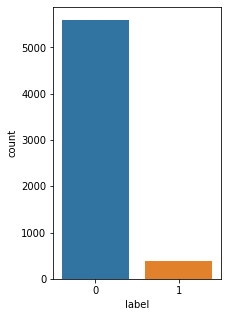

In [21]:
import seaborn as sns
fig= plt.figure(figsize=(3,5))
sns.countplot(x='label', data = df);

In [22]:
# This is imbalanced data. There are some ways to deal with this problem. 

In [23]:
words_cleaned = word_tokenize("".join(cleaned_tweet_list))
print(f"The number of words is {len(words_cleaned)}\n")
for word in words_cleaned[:FIRST_N_RECORDS]:
  print(word)

The number of words is 38665

oooo
tomorrowopened
rollerblade
season
today
summer
rollerblading
belgrade
adaciganlijafather
dayhype


In [24]:
from nltk.probability import FreqDist
freq_dist= FreqDist(words_cleaned)
freq_dist.most_common(10)

[('day', 346),
 ('love', 336),
 ('amp', 326),
 ('like', 184),
 ('life', 164),
 ('new', 158),
 ('happy', 150),
 ('today', 135),
 ('see', 128),
 ('get', 126)]

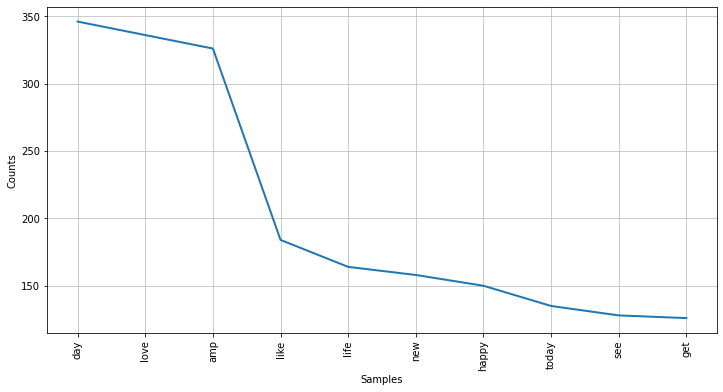

In [25]:
fig= plt.figure(figsize=(12,6))
freq_dist.plot(10)

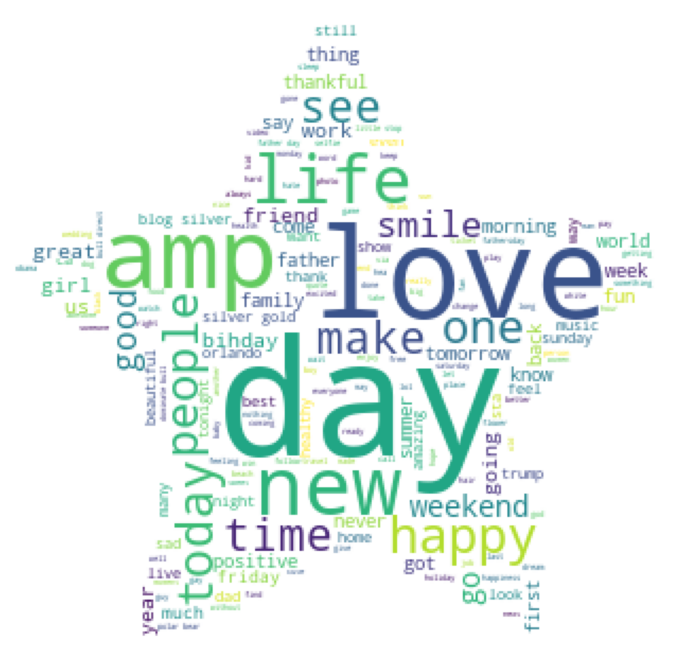

In [26]:
#Library to form wordcloud :
from wordcloud import WordCloud, ImageColorGenerator
import requests
import numpy as np
from PIL import *

Mask = np.array(Image.open(requests.get('http://clipart-library.com/data_images/224.jpg', stream=True).raw))

image_colors = ImageColorGenerator(Mask)

wordcloud = WordCloud(background_color='white', height=1500, width=4000,mask=Mask,).generate("".join(cleaned_tweet_list))

#Plot the wordcloud :
plt.figure(figsize = (12, 12)) 
plt.imshow(wordcloud) 

#To remove the axis value :
plt.axis("off") 
plt.show()

In [27]:
# Stemming 
from nltk.stem import PorterStemmer
ps = PorterStemmer()
[(word, ps.stem(word)) for word in words_cleaned[:FIRST_N_RECORDS]]

[('oooo', 'oooo'),
 ('tomorrowopened', 'tomorrowopen'),
 ('rollerblade', 'rollerblad'),
 ('season', 'season'),
 ('today', 'today'),
 ('summer', 'summer'),
 ('rollerblading', 'rollerblad'),
 ('belgrade', 'belgrad'),
 ('adaciganlijafather', 'adaciganlijafath'),
 ('dayhype', 'dayhyp')]

In [28]:
# Lemmatization
from nltk import WordNetLemmatizer
wnl = WordNetLemmatizer()
[(word, wnl.lemmatize(word)) for word in words_cleaned[:FIRST_N_RECORDS]]

[('oooo', 'oooo'),
 ('tomorrowopened', 'tomorrowopened'),
 ('rollerblade', 'rollerblade'),
 ('season', 'season'),
 ('today', 'today'),
 ('summer', 'summer'),
 ('rollerblading', 'rollerblading'),
 ('belgrade', 'belgrade'),
 ('adaciganlijafather', 'adaciganlijafather'),
 ('dayhype', 'dayhype')]

In [29]:
# Part-of-Speech
tag = nltk.pos_tag(words_cleaned[:FIRST_N_RECORDS])
tag

[('oooo', 'NN'),
 ('tomorrowopened', 'VBD'),
 ('rollerblade', 'NN'),
 ('season', 'NN'),
 ('today', 'NN'),
 ('summer', 'NN'),
 ('rollerblading', 'VBG'),
 ('belgrade', 'NN'),
 ('adaciganlijafather', 'NN'),
 ('dayhype', 'NN')]

In [30]:
for sentence in df.tweet.to_list()[:FIRST_N_RECORDS]:
  print(nltk.pos_tag(word_tokenize(sentence)))

[('oooo', 'NN'), ('tomorrow', 'NN')]
[('opened', 'VBN'), ('rollerblade', 'NN'), ('season', 'NN'), ('today', 'NN'), ('summer', 'NN'), ('rollerblading', 'VBG'), ('belgrade', 'NN'), ('adaciganlija', 'NN')]
[('father', 'RB'), ('day', 'NN')]
[('hype', 'NN'), ('min', 'NN'), ('go', 'VBP'), ('super', 'NN')]
[('eating', 'VBG'), ('breakfast', 'NN'), ('hear', 'JJ'), ('sad', 'JJ'), ('sounds', 'NNS'), ('packing', 'VBG'), ('vacation', 'NN'), ('seemed', 'VBD'), ('shoer', 'JJ'), ('others', 'NNS')]
[('oh', 'UH'), ('noooo', 'JJ'), ('fine', 'JJ'), ('going', 'VBG'), ('flow', 'JJ'), ('epic', 'NN'), ('cantsleeptonight', 'NN')]
[('happy', 'JJ'), ('bihday', 'NN'), ('junior', 'JJ'), ('hope', 'NN'), ('best', 'JJS'), ('day', 'NN'), ('bihday', 'NN'), ('cristiano', 'NN')]
[('happy', 'JJ'), ('bihday', 'NN'), ('brithday', 'JJ'), ('day', 'NN'), ('holidays', 'NNS'), ('monday', 'VBP')]
[('freaking', 'VBG'), ('love', 'NN'), ('selfies', 'NNS'), ('alldayeveryday', 'VBP'), ('makes', 'VBZ'), ('goodhairday', 'JJ'), ('makeup'

In [31]:
X = df.tweet
y = df.label

In [32]:
X.head(FIRST_N_RECORDS)

0                                                                 oooo tomorrow
1    opened rollerblade season today summer rollerblading belgrade adaciganlija
2                                                                    father day
3                                                             hype min go super
4         eating breakfast hear sad sounds packing vacation seemed shoer others
5                                oh noooo fine going flow epic cantsleeptonight
6                            happy bihday junior hope best day bihday cristiano
7                                     happy bihday brithday day holidays monday
8         freaking love selfies alldayeveryday makes goodhairday makeup onpoint
9                                                 find nationalities happy days
Name: tweet, dtype: object

**Model building and Executing the model to make prediction.**

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
feature_vector = vectorizer.fit_transform(X)
feature_vector.shape

(5972, 12601)

In [34]:
# Vocabulary of the vectorizer
len(vectorizer.vocabulary_)

12601

In [35]:
feature_vector.shape

(5972, 12601)

In [36]:
# idf scores of each word
idf_scores = dict(zip(vectorizer.get_feature_names(),vectorizer.idf_ ))

In [37]:
idf_scores.get('love')

3.5969303105660657

In [38]:
max(idf_scores.values())

9.001857412172361

In [39]:
# The top 10 words which have highest idf
from collections import Counter
counter = Counter(idf_scores)
counter.most_common(10)

[('aa', 9.001857412172361),
 ('aaaaa', 9.001857412172361),
 ('aaaaaand', 9.001857412172361),
 ('aaaaah', 9.001857412172361),
 ('aaahhhhh', 9.001857412172361),
 ('aaawwwww', 9.001857412172361),
 ('aah', 9.001857412172361),
 ('aaliyah', 9.001857412172361),
 ('aascf', 9.001857412172361),
 ('aayat', 9.001857412172361)]

In [40]:
# The top 10 words which have lowest idf (These words are so common in the whole corpus)
for key in sorted(counter, key=counter.get, reverse=False)[:FIRST_N_RECORDS]:
  score = idf_scores.get(key)
  print(key, score)

love 3.5969303105660657
day 3.7060431758424426
amp 3.9878943279834305
happy 4.011424825393624
today 4.324366564604643
life 4.3384183180602935
new 4.371994613593898
like 4.39169968467323
one 4.565105877809232
good 4.619830777498478


In [41]:
X_dense = feature_vector.todense()
X_dense.shape

(5972, 12601)

In [42]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [43]:
def summarize_classification(y_test, y_pred):

    acc = accuracy_score(y_test, y_pred, normalize=True)
    num_acc = accuracy_score(y_test, y_pred, normalize=False)
    prec = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    print("Length of testing data: ", len(y_test))
    print("accuracy_count : " , num_acc)
    print("accuracy_score : " , acc)
    print("precision_score : " , prec)
    print("recall_score : ", recall)

In [44]:
X_train, X_test, y_train, y_test = train_test_split( X_dense, y, test_size=0.20, random_state=42)

In [45]:
clf = GaussianNB().fit(X_train, y_train)

In [46]:
y_pred = clf.predict(X_test) 
summarize_classification(y_test, y_pred)

Length of testing data:  1195
accuracy_count :  1081
accuracy_score :  0.9046025104602511
precision_score :  0.9227628408527871
recall_score :  0.9046025104602511
